In [1]:
# %pip install openpyxl
# %pip install seaborn
# %pip install pygris

# X Industry is Y more likely to have employees in violation
#      Share of Employees Employed in Violation by Indsutry

# X Industry has $Y in Back Wages per Employee Receiving Back Wages
#      When back wages are owed by industry, each employee gets how much $

# X Industry has Y employees owed back wages out of Z total payroll employees
#      How common is the back wages by industry?

# https://labor.fiu.edu/publications/faculty-publications/wage-theft-report-for-hillsborough-county.pdf
#      68% of 4,387 low-wage workers in CHI, LAX, NYC had at least 1 wage theft experience
#      Given 1 wage theft experience, workers lost 15% of $17,616 annual earnings
#      Place of Victim Residence --- ACS Employed Household Income by NAICS
#      Place of Victim Employment --- Zip Business Patterns by NAICS


#      wage theft by tract (res) = # employed * (15% * $ earned expected) by NAICS ... assume employee counts and earnings
#      wage theft by tract (emp) = annual payroll * 115% by NAICS ... assume payrolls are short 15%

# https://api.census.gov/data/2018/zbp/variables.html
#      https://api.census.gov/data/2018/zbp?get=NAME,GEO_ID,NAICS2017_LABEL,PAYANN,ESTAB,EMP&for=zip%20code:90210&NAICS2017=23
#      ZCTA by NAICS number of employees (EMP), number of business (ESTAB), annual payroll (PAYANN)
#      https://www.census.gov/programs-surveys/economic-census/year/2022/guidance/understanding-naics.html
#      https://data.census.gov/map/040XX00US12$8600000/ACSST5Y2022/S0101?q=naics&layer=VT_2022_860_Z2_PY_D1&loc=28.2392,-82.4491,z9.6493

# https://files.epi.org/pdf/125116.pdf

In [2]:
import pandas as pd
import openpyxl
import seaborn as sns
from pygris import zctas,counties
import matplotlib.pyplot as plt

In [3]:
path1   = "https://www.dol.gov/sites/dolgov/files/WHD/data/2023/sheets/h2b.xlsx"
path2   = "https://www.dol.gov/sites/dolgov/files/WHD/data/2023/sheets/low-wage-high-violation.xlsx"
api_key = 'XXX' # get US Census API Key

In [4]:
df1         = pd.read_excel(path1).loc[:8].T
df1_cols    = ['year','metric'] + df1.loc['Compliance Action Summary',2:].str.lower().to_list()
df1         = df1.reset_index(drop=True).loc[1:,:]
df1.columns = df1_cols
for i in [1,6,11,16,21,26,31,36,41,46,51]:
    df1.loc[i:i+4].loc[:,'year'] = pd.to_datetime(df1.loc[i].year[-4:])
df1.set_index('year',inplace=True)
df1 = pd.melt(df1,id_vars='metric', var_name='industry',value_name='value', ignore_index=False)

for i in df1.industry.unique():    
    for year in df1.index.unique():
        val_backwages = df1.loc[(df1.industry==i) &
                             (df1.index.isin([year])) &
                             (df1.metric.isin(['Back Wages'])),'value'].iloc[0]
        val_employees = df1.loc[(df1.industry==i) &
                             (df1.index.isin([year])) &
                             (df1.metric.isin(['Employees Receiving Back Wages'])),'value'].iloc[0]
        calc_value    = val_backwages / val_employees
        
        data = {'metric':'Back Wages per Employee', 'industry':i,'value':calc_value}
        new_row_df = pd.DataFrame([data])
        new_row_df.index = [pd.to_datetime(year)]
        df1 = pd.concat([df1,new_row_df])

In [5]:
df2         = pd.read_excel(path2).T
df2_cols    = ['year','metric'] + df2.loc['Low Wage, High Violation Industries',2:].str.lower().to_list()
df2         = df2.reset_index(drop=True).loc[1:,:]
df2.columns = df2_cols
for i in [1,5,9,13,17,21,25,29,33,37,41]:
    df2.loc[i:i+3].loc[:,'year'] = pd.to_datetime(df2.loc[i].year[-4:])
df2.set_index('year',inplace=True)
df2 = pd.melt(df2,id_vars='metric', var_name='industry',value_name='value', ignore_index=False)
df2.loc[df2.metric=='Employees Receiving Back Wages Receiving Back Wages','metric'] = 'Employees Receiving Back Wages'

for i in df2.industry.unique():    
    for year in df2.index.unique():
        val_backwages = df2.loc[(df2.industry==i) &
                             (df2.index.isin([year])) &
                             (df2.metric.isin(['Back Wages'])),'value'].iloc[0]
        val_employees = df2.loc[(df2.industry==i) &
                             (df2.index.isin([year])) &
                             (df2.metric.isin(['Employees Receiving Back Wages'])),'value'].iloc[0]
        calc_value    = val_backwages / val_employees
        
        data = {'metric':'Back Wages per Employee', 'industry':i,'value':calc_value}
        new_row_df = pd.DataFrame([data])
        new_row_df.index = [pd.to_datetime(year)]
        df2 = pd.concat([df2,new_row_df])

In [6]:
df = pd.concat([df1,df2])
df.head(5)

,metric,industry,value
2023-01-01,Compliance Actions,forestry,19
2023-01-01,Employees Employed in Violation,forestry,833
2023-01-01,Employees Receiving Back Wages,forestry,784
2023-01-01,Back Wages,forestry,1490542.95
2023-01-01,Civil Money Penalties Assessed,forestry,642160.4


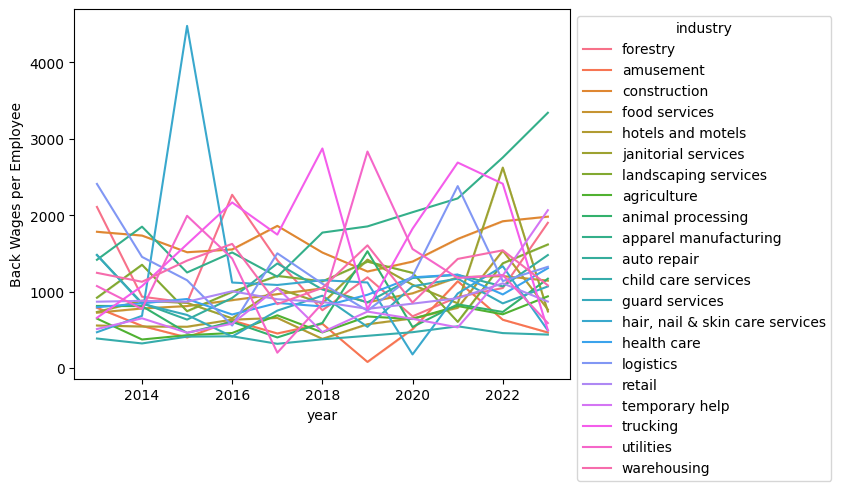

In [7]:
# After plotting Back Wages per Employee trends, we can use a 10yr mean per industry for wage theft estimates

df_to_plot = df.loc[df.metric=='Back Wages per Employee'][['industry','value']]
df_to_plot.columns = ['industry','Back Wages per Employee']

ax = sns.lineplot(data=df_to_plot, x=df_to_plot.index, y='Back Wages per Employee', hue='industry')
ax.set_xlabel('year')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [8]:
df_to_plot = df.loc[df.metric=='Back Wages per Employee'][['industry','value']]
df_to_plot.columns = ['industry','Back Wages per Employee']

df_bw_post2018 = df_to_plot.loc[df_to_plot.index>pd.to_datetime('2018')].groupby('industry').mean().sort_values(by=df_to_plot.columns[1],ascending=False)
df_bw_pre2018  = df_to_plot.loc[df_to_plot.index<pd.to_datetime('2018')].groupby('industry').mean().sort_values(by=df_to_plot.columns[1],ascending=False)

df_bw_means = pd.concat([df_bw_pre2018,df_bw_post2018],axis=1)
df_bw_means.columns = ["Pre-2018, Back Wages per Employee","Post-2018, Back Wages per Employee"]
df_bw_means['Diff'] = df_bw_means['Post-2018, Back Wages per Employee'] - df_bw_means['Pre-2018, Back Wages per Employee']
df_bw_means['Percent Diff'] = 100*(df_bw_means['Diff'] / df_bw_means['Pre-2018, Back Wages per Employee'])

df_bw_means.sort_values(by='Percent Diff',ascending=False)

,"Pre-2018, Back Wages per Employee","Post-2018, Back Wages per Employee",Diff,Percent Diff
industry,,,,
apparel manufacturing,1445.516452,2441.942623,996.426171,68.932192
janitorial services,833.067045,1344.631514,511.564468,61.407359
temporary help,651.295293,1038.889413,387.594119,59.511273
animal processing,618.370617,961.045518,342.674901,55.41578
hotels and motels,586.899196,863.392873,276.493677,47.110931
agriculture,520.586001,754.559134,233.973133,44.944185
health care,820.232532,1128.116888,307.884356,37.536228
utilities,1095.259866,1475.691639,380.431774,34.734385
food services,835.06637,1075.646227,240.579857,28.809669


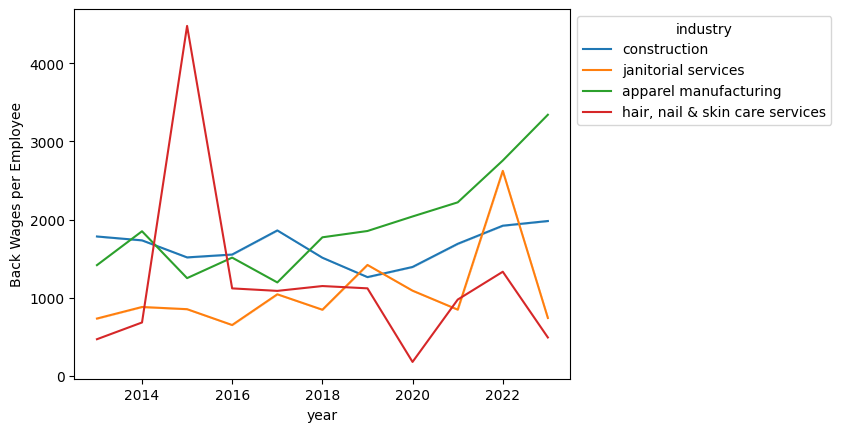

In [9]:
df_filtered = df_to_plot.loc[df_to_plot.industry.isin(['apparel manufacturing','janitorial services','construction','hair, nail & skin care services'])]

ax = sns.lineplot(data=df_filtered, x=df_filtered.index, y='Back Wages per Employee', hue='industry')
ax.set_xlabel('year')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [10]:
county = 'Pasco'

gpd_county_pasco = counties(state='FL',year=2018,cache=False)
gpd_county_pasco = gpd_county_pasco.loc[gpd_county_pasco.NAME==county]

gpd_zctas_pasco = zctas(year = 2018, cache = True, subset_by=gpd_county_pasco)

df.loc[df.metric=='Employees Receiving Back Wages'].sort_values(by='value',ascending=False).drop_duplicates('industry').head(5)

Using FIPS code '12' for input 'FL'


,metric,industry,value
2013-01-01,Employees Receiving Back Wages,food services,48327
2019-01-01,Employees Receiving Back Wages,health care,39011
2019-01-01,Employees Receiving Back Wages,construction,38218
2018-01-01,Employees Receiving Back Wages,hotels and motels,24432
2019-01-01,Employees Receiving Back Wages,retail,18280


In [11]:
"""
Top 5 by employees receiving back wages is

'72,62,23,71,44,45'

2022 NAICS
11	Agriculture, Forestry, Fishing and Hunting
21	Mining, Quarrying, and Oil and Gas Extraction
22	Utilities
23	Construction
31-33	Manufacturing
42	Wholesale Trade
44-45	Retail Trade
48-49	Transportation and Warehousing
51	Information
52	Finance and Insurance
53	Real Estate and Rental and Leasing
54	Professional, Scientific, and Technical Services
55	Management of Companies and Enterprises
56	Administrative and Support and Waste Management and Remediation Services
61	Educational Services
62	Health Care and Social Assistance
71	Arts, Entertainment, and Recreation
72	Accommodation and Food Services
81	Other Services (except Public Administration)
92	Public Administration (not covered in economic census)

2017 NAICS ***needed for 2018 ZIPs
11	Agriculture, Forestry, Fishing and Hunting
21	Mining, Quarrying, and Oil and Gas Extraction
22	Utilities
23	Construction
31-33	Manufacturing
42	Wholesale Trade
44-45	Retail Trade
48-49	Transportation and Warehousing
51	Information
52	Finance and Insurance
53	Real Estate and Rental and Leasing
54	Professional, Scientific, and Technical Services
55	Management of Companies and Enterprises
56	Administrative and Support and Waste Management and Remediation Services
61	Educational Services
62	Health Care and Social Assistance
71	Arts, Entertainment, and Recreation
72	Accommodation and Food Services
81	Other Services (except Public Administration)
92	Public Administration
"""

"\nTop 5 by employees receiving back wages is\n\n'72,62,23,71,44,45'\n\n2022 NAICS\n11\tAgriculture, Forestry, Fishing and Hunting\n21\tMining, Quarrying, and Oil and Gas Extraction\n22\tUtilities\n23\tConstruction\n31-33\tManufacturing\n42\tWholesale Trade\n44-45\tRetail Trade\n48-49\tTransportation and Warehousing\n51\tInformation\n52\tFinance and Insurance\n53\tReal Estate and Rental and Leasing\n54\tProfessional, Scientific, and Technical Services\n55\tManagement of Companies and Enterprises\n56\tAdministrative and Support and Waste Management and Remediation Services\n61\tEducational Services\n62\tHealth Care and Social Assistance\n71\tArts, Entertainment, and Recreation\n72\tAccommodation and Food Services\n81\tOther Services (except Public Administration)\n92\tPublic Administration (not covered in economic census)\n\n2017 NAICS ***needed for 2018 ZIPs\n11\tAgriculture, Forestry, Fishing and Hunting\n21\tMining, Quarrying, and Oil and Gas Extraction\n22\tUtilities\n23\tConstructi

In [12]:
# Pulling data from api.census.gov

var_strlist   = 'NAME,GEO_ID,NAICS2017_LABEL,EMPSZES_LABEL,PAYANN,ESTAB,EMP'
zip_code      = ','.join(str(x) for x in gpd_zctas_pasco.GEOID10.unique())
naics_strlist = '00'#,72,62,23,71,44,45'


url = f"https://api.census.gov/data/2018/zbp?get={var_strlist}&for=zip%20code:{zip_code}&NAICS2017={naics_strlist}&key={api_key}"

var_names  = {'NAME':f'zip_name',
              'NAICS2017_LABEL':f'naics_ind_name',
              'EMPSZES':'employee_size_class',
              'PAYANN':f'sum_ann_payroll',
              'ESTAB':f'count_establishments',
              'EMP':f'count_employees',
              'NAICS2017':'naics_ind_code',
              'zip code':'zipcode'}

df_zip_naics     = pd.read_json(url)
df_zip_naics     = df_zip_naics.rename(columns=df_zip_naics.iloc[0]).drop(df_zip_naics.index[0])
df_zip_naics     = df_zip_naics.rename(columns=var_names)
df_zip_naics[['sum_ann_payroll','count_establishments','count_employees']] = df_zip_naics[['sum_ann_payroll','count_establishments','count_employees']].astype(int)

df_zip_naics = pd.concat([pd.DataFrame(),df_zip_naics])

df_zip_naics.head(5)

,zip_name,GEO_ID,naics_ind_name,EMPSZES_LABEL,sum_ann_payroll,count_establishments,count_employees,naics_ind_code,zipcode
1,"ZIP 34637 (Land O Lakes, FL)",8610000US34637,Total for all sectors,All establishments,26437,73,635,00,34637
2,"ZIP 34637 (Land O Lakes, FL)",8610000US34637,Total for all sectors,Establishments with less than 5 employees,0,59,0,00,34637
3,"ZIP 34637 (Land O Lakes, FL)",8610000US34637,Total for all sectors,Establishments with 5 to 9 employees,0,5,0,00,34637
4,"ZIP 34637 (Land O Lakes, FL)",8610000US34637,Total for all sectors,Establishments with 10 to 19 employees,0,3,0,00,34637
5,"ZIP 34637 (Land O Lakes, FL)",8610000US34637,Total for all sectors,Establishments with 20 to 49 employees,0,3,0,00,34637


Text(0.5, 1.0, 'Pasco count_employees by Zip Codes, 2018')

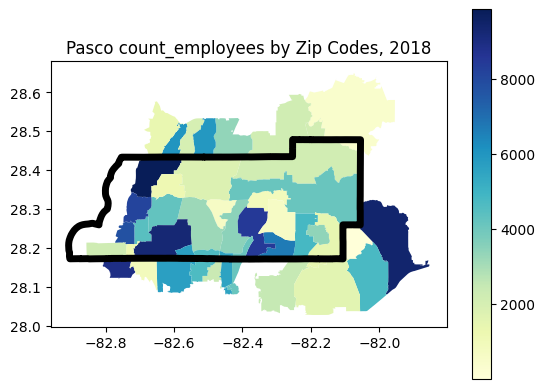

In [13]:
col = 'count_employees'

plotdf = gpd_zctas_pasco.merge(df_zip_naics.loc[(df_zip_naics.count_employees.astype(int)>0)&(df_zip_naics.sum_ann_payroll<1000000),[col,'zipcode']],left_on='GEOID10',right_on='zipcode')

fig, ax = plt.subplots()
plotdf[[col,'geometry']].plot(column=col,ax = ax, cmap='YlGnBu',legend=True)
gpd_county_pasco.plot(ax = ax,edgecolor='black', facecolor='none', linewidth=5)
plt.title(f'{county} {col} by Zip Codes, 2018')